In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import numpy as np
from model_utils import pipeline

2024-12-15 21:17:13.164578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734322633.197269   22962 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734322633.205357   22962 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 21:17:13.230547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
def create_targets(df, window_size, look_ahead):
    # Columns to use as features
    feature_columns = df.columns.drop('close')  # exclude 'close' if it's the target

    # Lists to hold windows and targets
    X_windows = []
    y_targets = []

    # Loop to create windows and look-ahead targets
    for i in range(len(df) - window_size - look_ahead):
        # Create the input window of size `window_size`
        X_window = df.iloc[i : i + window_size][feature_columns].values
        
        # Calculate targets based on the look-ahead period
        future_prices = df['close'].iloc[i + window_size : i + window_size + look_ahead].values
        current_price = df['close'].iloc[i + window_size - 1]
        

        # Calculate max price and min price using the buffers
        max_price = np.max(future_prices)
        min_price = np.min(future_prices)

        # Calculate the target percentages
        target_max = (max_price - current_price) / current_price
        target_min = -(current_price - min_price) / current_price
                
        # Append window and target
        X_windows.append(X_window)
        y_targets.append([target_max, target_min])

    #scaler_y = MinMaxScaler(feature_range=(-1, 1))
    #y_targets = scaler_y.fit_transform(y_targets)  # Fit and normalize
    
    # Convert lists to numpy arrays for modeling
    X = np.array(X_windows)  # Shape: (num_windows, window_size, num_features)
    y = np.array(y_targets)  # Shape: (num_windows, 2) for max, min
    
    return(X,y)


In [3]:
# trade_threshold: the predicted % above current price to place a trade at
# prediction_tolerance_max: The percent of the predicted % to place the tp
# prediction_tolerance_min:  The percent of the predicted % to place the sl
# Trading Fee is small (0.1%)

# Function tests a model to check its profitability
def simulate_trading(model, prediction_tolerance_max, prediction_tolerance_min, X_test, y_test, y_train, 
trade_threshold):
    
    # Create prediictions based on X_test
    predictions = model.predict(X_test)
   
    scaler_y = MinMaxScaler(feature_range=(-1, 1))  # Scale to [-1, 1]
    scaler_y.fit(y_train)

    predictions_rescaled = scaler_y.inverse_transform(predictions)
    y_test = scaler_y.inverse_transform(y_test)


    total_profit = 0
    tot_take_profit = []
    tot_stop_loss = []
    fee = 0.2
    print(f'Predictions:{predictions_rescaled[:10]}')
    print(f'Y-Tests:{y_test[:10]}')

    # Go through all the predictions 
    for frame in range(len(predictions_rescaled)):
        # If the trade_threshold is reached place a trade 
        if predictions_rescaled[frame][0] >= trade_threshold:
            
            # Calculate the take profits
            take_profit = predictions_rescaled[frame][0] * prediction_tolerance_max
            tot_take_profit.append(take_profit)

            # Calcuate the stop losses
            stop_loss = predictions_rescaled[frame][1] * prediction_tolerance_min
            tot_stop_loss.append(stop_loss)

            # If the trade was profitable return the profit
            if take_profit >= y_test[frame][0]:
                profit = take_profit
            # Unprofitable trades return the stoploss
            else:
                profit = stop_loss
            total_profit = total_profit + profit - fee
        else:
            tot_take_profit.append(0)
            tot_stop_loss.append(0)

    
    print(f'TP:{tot_take_profit[:10]}')
    print(f'SL:{tot_stop_loss[:10]}')

    # Return negative profit as something to minamize
    print(f'Tot Profit: {total_profit}')
    return -total_profit, X_test, y_test,  predictions

In [33]:
data = pipeline()
data.load_file(filename="data/DOGEUSD_15m_vo.csv")
df = data.data

Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


In [27]:
X, y_scaled = create_targets(df.head(10000), 125, 37)

In [34]:
X, y_unscaled = create_targets(df.head(10000), 125, 37)

In [36]:
def distribution(data, bins = 30):   
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Sample data
    import numpy as np

    # Plot distribution with KDE
    sns.histplot(data, kde=True, bins=bins, color='blue')
    plt.title('Distribution with KDE')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()


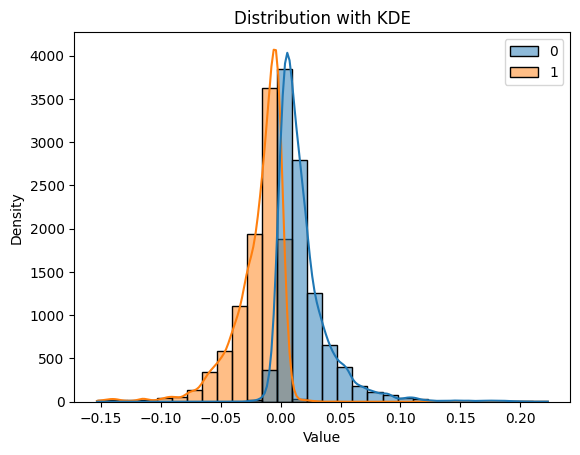

In [37]:
distribution(y_unscaled)

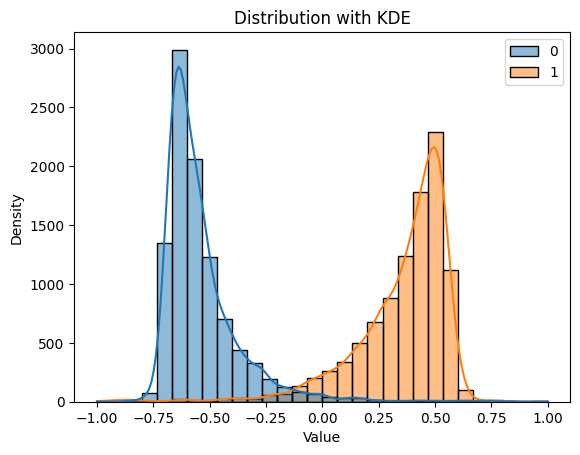

In [38]:
distribution(y_scaled)

In [41]:

scaler_y = MinMaxScaler(feature_range=(-1, 1))  # Scale to [-1, 1]
scaler_y.fit(y_unscaled)

y = scaler_y.inverse_transform(y_scaled)


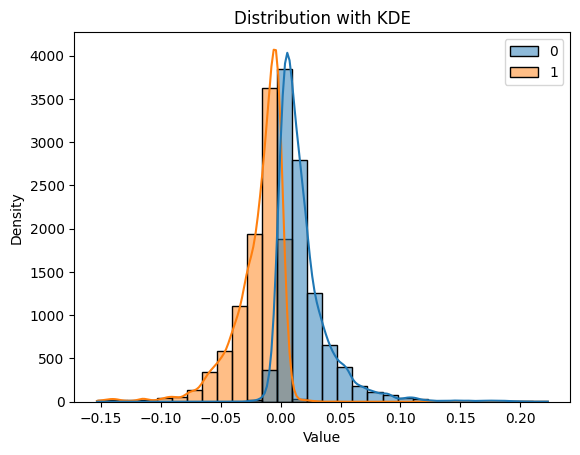

In [42]:
distribution(y)